# Warm start SVGP with equivalent observations

This notebook illustrates how to use the concept of equivalent observations to initialise and SVGP model.

First, let's load some required packages

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio


rng = np.random.RandomState(123)
tf.random.set_seed(42)

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));

# Plot the model
def plot_mean_conf(x, mean, var, ax, color='C0', alpha=1.):
        ax.plot(x, mean, color, lw=2, alpha=alpha)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=alpha * 0.2,
        )

def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0', alpha=1.):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)[:2]
    plot_mean_conf(x, mean, var, ax, color, alpha)

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


For this notebook we will reuse one example from the GPflow documentation

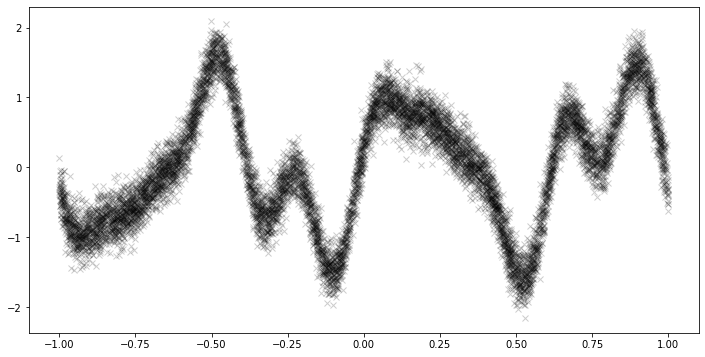

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 10000  # Number of training observations

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
data = (X, Y)

plt.plot(X, Y, "kx", alpha=.2)

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-08-08 09:30:21.398973: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-08 09:30:22.227624: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.06291 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.09354 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.04553 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

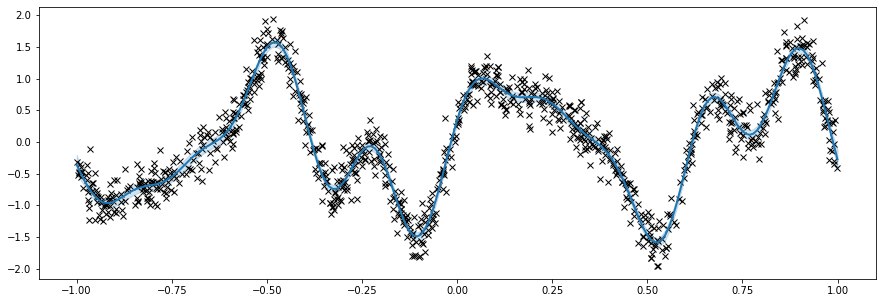

In [3]:
kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscales=0.1)
m = gpflow.models.GPR(data=(X[:1000], Y[:1000]), kernel=kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot_model(m, ax, np.linspace(-1, 1, 200)[:, None])

We fit a classic SVGP model with 50 inducing points taken uniformly in the input space

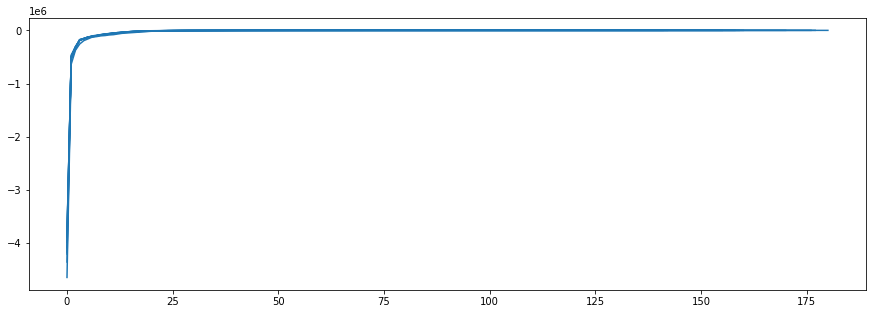

In [4]:
maxiter=2000
M = 50  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscales=0.1)
gpflow.utilities.set_trainable(kernel, False)

lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(0.05)
gpflow.set_trainable(lik, False)


def callback(x):
    global trace
    trace += [training_loss()]

rng = np.random.RandomState(123)
    
XX = rng.rand(N, 20) * 2 - 1
YY = func(XX) + 0.2 * rng.randn(N, 20)
ZZ = np.zeros((M, 20))
LL = np.zeros((N, 20))
for i in range(20):
    z, l = scipy.cluster.vq.kmeans2(XX[:, i:i+1], M, minit='points')
    ZZ[:, i:i+1] = z
    LL[:, i] = l


Traces = np.nan * np.zeros((maxiter, 20))
for i in range(10):
    X = XX[:, i:i+1]
    Y = YY[:, i:i+1]
    Z = ZZ[:, i:i+1]
    label = LL[:, i] 

    m = gpflow.models.SVGP(kernel, lik, Z, num_data=N, whiten=False)
    gpflow.utilities.set_trainable(m.inducing_variable, False)

    training_loss = m.training_loss_closure((X, Y), compile=True)
    trace = []

    opt = gpflow.optimizers.Scipy()

    #opt.minimize(training_loss, m.trainable_variables, callback=callback)
    #n_it = len(trace)
    #gpflow.utilities.set_trainable(m.kernel, True)

    opt.minimize(training_loss, m.trainable_variables, callback=callback, options={'maxiter':maxiter})
    Traces[:len(trace), i] = trace

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(-Traces, "C0");



Now, let's fit 50 SVGP with one inducing point each, use equivalent observations to merge the ensemble predicions and use the result to warm start an SVGP optimisation...

-------- 0
-------- 1
-------- 2
-------- 3
-------- 4
-------- 5
-------- 6
-------- 7
-------- 8
-------- 9


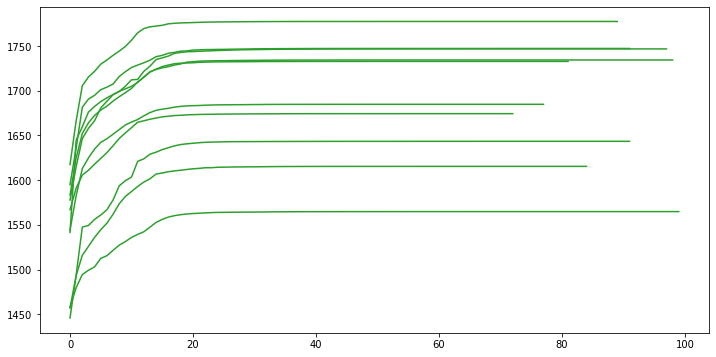

In [5]:
kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscales=0.1)
gpflow.set_trainable(kernel, False)

lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(0.05)
gpflow.set_trainable(lik, False)

mean_function = gpflow.mean_functions.Zero()

def get_subSVGP(X, Y, Z):
    models = []
    for i in range(M):
        X_ = X[label==i, :]
        Y_ = Y[label==i, :]
        q_mu = np.mean(Y_, keepdims=True)
        q_sqrt = np.std(Y_)/np.sqrt(Y_.shape[0])[None, None, None]
        model = gpflow.models.SVGP(inducing_variable=Z[i:i+1], likelihood=lik, kernel=kernel, mean_function=mean_function, q_mu = q_mu, q_sqrt=q_sqrt, whiten=False)
        #gpflow.utilities.set_trainable(model.inducing_variable, False)
        #opt.minimize(model.training_loss_closure((X_, Y_)), model.trainable_variables, options={'maxiter':5});
        models += [model]
    return(models)

def get_qmu_qsqrt_init(X, Y, Z):
    q_mu = np.zeros((M, 1))
    q_s_1 = np.zeros((M))
    for j in range(M):
        X_ = X[label==j, :]
        Y_ = Y[label==j, :]
        q_mu[j] = np.mean(Y_)
        q_s_1[j] = Y_.shape[0]/np.var(Y_)
    K_1 = np.linalg.inv(kernel(Z).numpy() + 1e-5 * np.eye(M))
    q_sqrt = np.linalg.cholesky(np.linalg.inv(K_1 + np.diag(q_s_1)) + 1e-5 * np.eye(M))
    return q_mu, q_sqrt[None, :, :]

Traces_eo = np.nan * np.zeros((maxiter, 20))

for i in range(10):
    print('--------', i)
    X = XX[:, i:i+1]
    Y = YY[:, i:i+1]
    Z = ZZ[:, i:i+1]
    label = LL[:, i] 
    
    #models = get_subSVGP(X, Y, Z)
    #m_agg = guepard.EquivalentObsEnsemble(models)
    #q_mu, q_sigma = m_agg.predict_f(Z, full_cov=True)
    #q_mu = q_mu.numpy()
    #q_sqrt = np.linalg.cholesky(q_sigma + 1e-4 * np.eye(M)[None, :, :])
    q_mu, q_sqrt = get_qmu_qsqrt_init(X, Y, Z) 
    model = gpflow.models.SVGP(inducing_variable=Z, likelihood=lik, kernel=kernel, mean_function=mean_function, q_mu = q_mu, q_sqrt=q_sqrt, whiten=False)
    
    gpflow.utilities.set_trainable(model.inducing_variable, False)
    training_loss = model.training_loss_closure((X, Y), compile=True)
    opt = gpflow.optimizers.Scipy()
    trace = []
    opt.minimize(training_loss, model.trainable_variables, callback=callback, options={'maxiter':maxiter})
    Traces_eo[:len(trace), i] = trace
    
plt.plot(-Traces_eo, "C2");

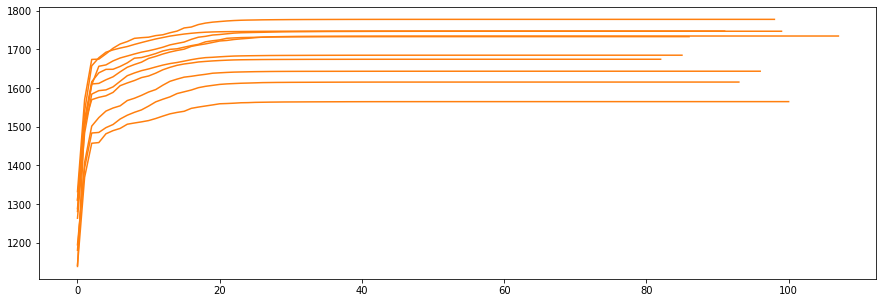

In [6]:
Traces_in = np.nan * np.zeros((maxiter, 20))
for i in range(10):
    X = XX[:, i:i+1]
    Y = YY[:, i:i+1]
    Z = ZZ[:, i:i+1]
    label = LL[:, i] 
    
    q_mu = np.zeros((M, 1))
    q_sqrt = np.zeros((1, M, M))
    for j in range(M):
        X_ = X[label==j, :]
        Y_ = Y[label==j, :]
        q_mu[j] = np.mean(Y_)
        q_sqrt[0, j, j] = np.std(Y_)/np.sqrt(Y_.shape[0])

    m = gpflow.models.SVGP(kernel, lik, Z, num_data=N, q_mu=q_mu, q_sqrt=q_sqrt, whiten=False)
    gpflow.utilities.set_trainable(m.inducing_variable, False)

    training_loss = m.training_loss_closure((X, Y), compile=True)
    trace = []

    opt = gpflow.optimizers.Scipy()

    #opt.minimize(training_loss, m.trainable_variables, callback=callback)
    #n_it = len(trace)
    #gpflow.utilities.set_trainable(m.kernel, True)

    opt.minimize(training_loss, m.trainable_variables, callback=callback, options={'maxiter':maxiter})
    Traces_in[:len(trace), i] = trace

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(-Traces_in, "C1");


Text(0, 0.5, 'ELBO')

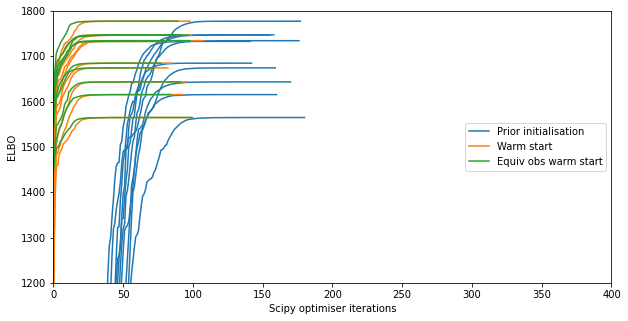

In [8]:
#Traces_eo_basic = Traces_eo
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot([], "C0", label="Prior initialisation")
plt.plot([], "C1", label="Warm start")
plt.plot([], "C2", label="Equiv obs warm start")

plt.plot(-Traces, "C0")
plt.plot(-Traces_in, "C1")
plt.plot(-Traces_eo, "C2")
plt.ylim((1200, 1800))
plt.legend(loc=5)
plt.xlim((0, 400))
plt.xlabel("Scipy optimiser iterations")
plt.ylabel("ELBO")